## Building basic likelihoods

In [1]:
import sys
import os
import glob
import importlib

import tqdm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pp

%matplotlib inline

In [3]:
import jax
jax.config.update('jax_enable_x64', True)

import jax.random
import jax.numpy as jnp

In [4]:
import discovery as ds
import discovery.models.nanograv as ds_nanograv
import discovery.samplers.numpyro as ds_numpyro

In [5]:
import discovery.metamatrix as mm
import discovery.metamath as mh

Read nanograv pulsars

In [6]:
allpsrs = [ds.Pulsar.read_feather(psrfile) for psrfile in sorted(glob.glob('../data/*-[JB]*.feather'))]

In [7]:
psr = allpsrs[0]

In [8]:
importlib.reload(mm)
importlib.reload(mh)
importlib.reload(ds.likelihood)
importlib.reload(ds)

<module 'discovery' from '/Users/vallis/Documents/discovery/src/discovery/__init__.py'>

## Graph tests

Simple graph, all constants, will be reduced to constant.

In [9]:
@mm.graph
def sumtwo(graph, a, b):
    a2 = 2 * a
    b3 = 3 * b
    result = a2 + b3

In [10]:
g = sumtwo(1,2)

In [11]:
mm.print_graph(g);

## graph
a: const = 1
b: const = 2
n0: node(a) = 2 * a
n1: node(b) = 3 * b
n2: node(n0, n1) = n0 + n1
# total array constants: 0 elements


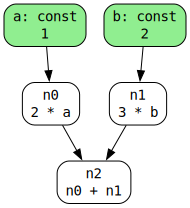

In [12]:
mm.visualize_graph(g)

Now `fold_constants` prunes directly

In [13]:
g1 = mm.fold_constants(g)

In [14]:
mm.print_graph(g1);

## graph
n2: const = 8
# total array constants: 0 elements


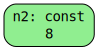

In [15]:
mm.visualize_graph(g1)

In [16]:
f = mm.func(g1)

In [17]:
f, f.args, f.params

(<function discovery.metamatrix.build_callable_from_graph.<locals>.f(*args, params={}) -> 'Array'>,
 [],
 [])

In [18]:
f()

8

Now with one argument, will be reduced partially, and create a function of one argument.

In [19]:
g = sumtwo(None, 2)

In [20]:
mm.print_graph(g);

## graph
a: arg
b: const = 2
n0: node(a) = 2 * a
n1: node(b) = 3 * b
n2: node(n0, n1) = n0 + n1
# total array constants: 0 elements


In [21]:
g1 = mm.fold_constants(g)

In [22]:
mm.print_graph(g1);

## graph
a: arg
n0: node(a) = 2 * a
n1: const = 6
n2: node(n0, n1) = n0 + n1
# total array constants: 0 elements


In [23]:
f = mm.func(g)

In [24]:
f, f.args, f.params

(<function discovery.metamatrix.build_callable_from_graph.<locals>.f(*args, params={}) -> 'Array'>,
 ['a'],
 [])

In [25]:
f(5)

16

In [26]:
f = mm.func(g1)

In [27]:
f, f.args, f.params

(<function discovery.metamatrix.build_callable_from_graph.<locals>.f(*args, params={}) -> 'Array'>,
 ['a'],
 [])

In [28]:
f(5)

16

One of the inputs is a graph. Everything folded.

In [29]:
@mm.graph
def double(graph, a):
    res = 2.5 * a

In [30]:
@mm.graph
def sumtwo(graph, a, b, f):
    result = f(a) + 3 * b

In [31]:
g = sumtwo(2, 3, double(None))

In [32]:
mm.print_graph(g)

## graph
a: const = 2
b: const = 3
f: graph = subgraph f[9a85]
n0: node(f, a) = f(a)
n1: node(b) = 3 * b
n2: node(n0, n1) = n0 + n1
# total array constants: 0 elements

## subgraph f[9a85]
a: arg
n0: node(a) = 2.5 * a
# total array constants: 0 elements


0

In [33]:
g1 = mm.fold_constants(sumtwo(2, 3, double(None)))

In [34]:
mm.print_graph(g1)

## graph
n2: const = 14.0
# total array constants: 0 elements


0

In [35]:
f = mm.func(g1)

In [36]:
f, f.args, f.params, f()

(<function discovery.metamatrix.build_callable_from_graph.<locals>.f(*args, params={}) -> 'Array'>,
 [],
 [],
 14.0)

One of the inputs is a function, cannot be evaluated immediately.

In [37]:
g = sumtwo(None, 3, double(None))

In [38]:
mm.print_graph(g)

## graph
a: arg
b: const = 3
f: graph = subgraph f[df89]
n0: node(f, a) = f(a)
n1: node(b) = 3 * b
n2: node(n0, n1) = n0 + n1
# total array constants: 0 elements

## subgraph f[df89]
a: arg
n0: node(a) = 2.5 * a
# total array constants: 0 elements


0

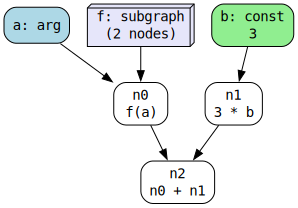

In [39]:
mm.visualize_graph(g)

In [40]:
g1 = mm.fold_constants(g)

In [41]:
mm.print_graph(g1);

## graph
a: arg
f: graph = subgraph f[abb1]
n0: node(f, a) = f(a)
n1: const = 9
n2: node(n0, n1) = n0 + n1
# total array constants: 0 elements

## subgraph f[abb1]
a: arg
n0: node(a) = 2.5 * a
# total array constants: 0 elements


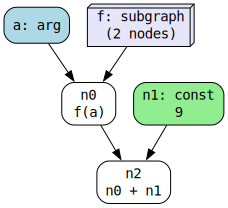

In [42]:
mm.visualize_graph(g1)

In [43]:
f = mm.func(g1)

In [44]:
f, f.args, f.params, f(4)

(<function discovery.metamatrix.build_callable_from_graph.<locals>.f(*args, params={}) -> 'Array'>,
 ['a'],
 [],
 19.0)

## Discovery components

Simple noise solver

In [45]:
@mm.graph
def noisesolve(graph, y, N):
    result = N.solve(y)

All constants

In [53]:
yvec = psr.residuals
Nvec = ds.makenoise_measurement(psr, noisedict=psr.noisedict).N

In [54]:
Nsolve = noisesolve(yvec, Nvec)

In [55]:
mm.print_graph(Nsolve)

## graph
y: const = array(shape=(7758,), dtype=float64)
N: const = array(shape=(7758,), dtype=float64)
n0: node(N, y) = solve(N, y)
# total array constants: 15516 elements


15516

In [56]:
mm.print_graph(mm.fold_constants(Nsolve))

## graph
n0: const = array(shape=(7758,), dtype=float64), array(shape=(), dtype=float64)
# total array constants: 7759 elements


7759

First empty argument

In [60]:
Nsolve = noisesolve(None, Nvec)

In [61]:
mm.print_graph(mm.fold_constants(Nsolve))

## graph
y: arg
N: const = array(shape=(7758,), dtype=float64)
n0: node(N, y) = solve(N, y)
# total array constants: 7758 elements


7758

In [63]:
f = mm.func(Nsolve)

In [64]:
f, f.args, f.params

(<function discovery.metamatrix.build_callable_from_graph.<locals>.f(*args, params={}) -> 'Array'>,
 ['y'],
 [])

In [67]:
f(yvec)

(array([-924684.05643357,  -15209.00619106, -256184.91074607, ...,
         457218.89618558, 3758690.70368335, 1397786.82265916],
       shape=(7758,)),
 Array(-209930.62020633, dtype=float64))

Works also for a matrix

In [66]:
Fmat = ds.makegp_ecorr(psr, noisedict=psr.noisedict).F

In [68]:
f(Fmat)

(array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 2.05907192e+11],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.94299584e+12],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 5.57914432e+11]],
       shape=(7758, 360)),
 Array(-209930.62020633, dtype=float64))

What if N is a function?

In [69]:
Nfunc = ds.makenoise_measurement(psr).getN

In [70]:
Nfunc.params

['B1855+09_430_ASP_efac',
 'B1855+09_430_PUPPI_efac',
 'B1855+09_L-wide_ASP_efac',
 'B1855+09_L-wide_PUPPI_efac',
 'B1855+09_430_ASP_log10_t2equad',
 'B1855+09_430_PUPPI_log10_t2equad',
 'B1855+09_L-wide_ASP_log10_t2equad',
 'B1855+09_L-wide_PUPPI_log10_t2equad']

In [71]:
Nsolve = noisesolve(yvec, Nfunc)

In [73]:
mm.print_graph(mm.fold_constants(Nsolve))

## graph
y: const = array(shape=(7758,), dtype=float64)
N: func = <function makenoise_measurement.<locals>.getnoise at 0x3a7aa5940>
n0: node(N, y) = solve(N, y)
# total array constants: 7758 elements


7758

In [74]:
f = mm.func(Nsolve)

In [75]:
f, f.args, f.params

(<function discovery.metamatrix.build_callable_from_graph.<locals>.f(*args, params={}) -> 'Array'>,
 [],
 ['B1855+09_430_ASP_efac',
  'B1855+09_430_ASP_log10_t2equad',
  'B1855+09_430_PUPPI_efac',
  'B1855+09_430_PUPPI_log10_t2equad',
  'B1855+09_L-wide_ASP_efac',
  'B1855+09_L-wide_ASP_log10_t2equad',
  'B1855+09_L-wide_PUPPI_efac',
  'B1855+09_L-wide_PUPPI_log10_t2equad'])

In [78]:
f(params = ds.sample_uniform(mm.func(Nsolve).params))

(Array([-982128.04105418,  -15218.17025395, -264191.96833687, ...,
         679368.8546547 , 5585717.19115331, 2076991.6114557 ],      dtype=float64),
 Array(-211349.10426805, dtype=float64))

Now keep y open

In [80]:
Nsolve = noisesolve(None, Nfunc)

In [81]:
mm.print_graph(mm.fold_constants(Nsolve))

## graph
y: arg
N: func = <function makenoise_measurement.<locals>.getnoise at 0x3a7aa5940>
n0: node(N, y) = solve(N, y)
# total array constants: 0 elements


0

In [83]:
f = mm.func(Nsolve)

In [84]:
f, f.args, f.params

(<function discovery.metamatrix.build_callable_from_graph.<locals>.f(*args, params={}) -> 'Array'>,
 ['y'],
 ['B1855+09_430_ASP_efac',
  'B1855+09_430_ASP_log10_t2equad',
  'B1855+09_430_PUPPI_efac',
  'B1855+09_430_PUPPI_log10_t2equad',
  'B1855+09_L-wide_ASP_efac',
  'B1855+09_L-wide_ASP_log10_t2equad',
  'B1855+09_L-wide_PUPPI_efac',
  'B1855+09_L-wide_PUPPI_log10_t2equad'])

In [85]:
f(yvec, params = ds.sample_uniform(mm.func(Nsolve).params))

(Array([-867347.29700373,  -13689.72434016, -235474.43546052, ...,
         516948.35394412, 4252102.32521468, 1580568.73902082],      dtype=float64),
 Array(-210560.84700017, dtype=float64))

Prior inverse

In [86]:
@mm.graph
def noiseinv(graph, P):
    result = P.inv()

In [87]:
Pmat = ds.makegp_ecorr(psr, noisedict=psr.noisedict).Phi.N

In [88]:
Pinv = noiseinv(Pmat)

In [89]:
mm.print_graph(mm.fold_constants(Pinv))

## graph
n0: const = array(shape=(360, 360), dtype=float64), array(shape=(), dtype=float64)
# total array constants: 129601 elements


129601

In [95]:
jnp.all(mm.func(Pinv)(params = {})[0] == jnp.diag(1/Pmat))

Array(True, dtype=bool)

In [96]:
Pfunc = ds.makegp_ecorr(psr).Phi.getN

In [97]:
Pfunc.params

['B1855+09_430_ASP_log10_ecorr',
 'B1855+09_430_PUPPI_log10_ecorr',
 'B1855+09_L-wide_ASP_log10_ecorr',
 'B1855+09_L-wide_PUPPI_log10_ecorr']

In [98]:
Pinv = noiseinv(Pfunc)

In [100]:
mm.print_graph(mm.fold_constants(Pinv))

## graph
P: func = <function makegp_ecorr.<locals>.getphi at 0x3f8a24ea0>
n0: node(P) = inv(P)
# total array constants: 0 elements


0

In [101]:
mm.func(Pinv).params

['B1855+09_430_ASP_log10_ecorr',
 'B1855+09_430_PUPPI_log10_ecorr',
 'B1855+09_L-wide_ASP_log10_ecorr',
 'B1855+09_L-wide_PUPPI_log10_ecorr']

In [102]:
mm.func(Pinv)(params=ds.sample_uniform(mm.func(Pinv).params))

(Array([[4.30665227e+11, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 4.30665227e+11, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 4.30665227e+11, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.17154219e+13, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 1.17154219e+13, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.17154219e+13]], dtype=float64),
 Array(-9973.8142587, dtype=float64))

Woodbury

In [153]:
@mm.graph
def noisesolve(graph, y, N):
    result = N.solve(y)

In [154]:
@mm.graph
def noiseinv(graph, P):
    result = P.inv()

In [155]:
@mm.graph
def woodbury(graph, y, Nsolve, F, Pinv):
    Nmy, lN = Nsolve(y)
    FtNmy = F.T @ Nmy

    NmF, _ = Nsolve(F)
    FtNmF = F.T @ NmF

    Pm, lP = Pinv
    cf, lS = graph.cho_factor(Pm + FtNmF)

    logp = -0.5 * (y.T @ Nmy - FtNmy.T @ graph.cho_solve(cf, FtNmy)) - 0.5 * (lN + lP + lS)

In [156]:
Nsolve = noisesolve(None, Nvec)
mm.print_graph(Nsolve)

## graph
y: arg
N: const = array((7758,))
n0: node(N, y) = solve(N, y)
# total array constants: 7758 elements


7758

In [157]:
Pinv = noiseinv(Pfunc)
mm.print_graph(Pinv)

## graph
P: func = <function makegp_ecorr.<locals>.getphi at 0x3f8a24ea0>
n0: node(P) = inv(P)
# total array constants: 0 elements


0

In [158]:
onewood = woodbury(yvec, Nsolve, Fmat, Pinv)

In [159]:
mm.print_graph(onewood)

## graph
y: const = array((7758,))
Nsolve: graph = subgraph Nsolve[80b4]
F: const = array((7758, 360))
Pinv: graph = subgraph Pinv[8793]
n0: node(Nsolve, y) = Nsolve(y)
n1: node(n0) = n0[0]
n2: node(n0) = n0[1]
n3: node(F) = F.T
n4: node(n3, n1) = n3 @ n1
n5: node(Nsolve, F) = Nsolve(F)
n6: node(n5) = n5[0]
n7: node(n5) = n5[1]
n8: node(F) = F.T
n9: node(n8, n6) = n8 @ n6
n10: node(Pinv) = Pinv[0]
n11: node(Pinv) = Pinv[1]
n12: node(n10, n9) = n10 + n9
n13: node(n12) = cho_factor(n12)
n14: node(n13) = n13[0]
n15: node(n13) = n13[1]
n16: node(y) = y.T
n17: node(n16, n1) = n16 @ n1
n18: node(n4) = n4.T
n19: node(n14, n4) = cho_solve(n14, n4)
n20: node(n18, n19) = n18 @ n19
n21: node(n17, n20) = n17 - n20
n22: node(n21) = -0.5 * n21
n23: node(n2, n11) = n2 + n11
n24: node(n23, n15) = n23 + n15
n25: node(n24) = 0.5 * n24
n26: node(n22, n25) = n22 - n25
# total array constants: 2800638 elements

## subgraph Nsolve[80b4]
y: arg
N: const = array((7758,))
n0: node(N, y) = solve(N, y)
# total a

2808396

In [160]:
mm.print_graph(mm.fold_constants(onewood))

## graph
Pinv: graph = subgraph Pinv[5f94]
n2: const = array(())
n4: const = array((360,))
n9: const = array((360, 360))
n10: node(Pinv) = Pinv[0]
n11: node(Pinv) = Pinv[1]
n12: node(n10, n9) = n10 + n9
n13: node(n12) = cho_factor(n12)
n14: node(n13) = n13[0]
n15: node(n13) = n13[1]
n17: const = 16556.999978853702
n18: const = array((360,))
n19: node(n14, n4) = cho_solve(n14, n4)
n20: node(n18, n19) = n18 @ n19
n21: node(n17, n20) = n17 - n20
n22: node(n21) = -0.5 * n21
n23: node(n2, n11) = n2 + n11
n24: node(n23, n15) = n23 + n15
n25: node(n24) = 0.5 * n24
n26: node(n22, n25) = n22 - n25
# total array constants: 130321 elements

## subgraph Pinv[5f94]
P: func = <function makegp_ecorr.<locals>.getphi at 0x3f8a24ea0>
n0: node(P) = inv(P)
# total array constants: 0 elements


130321

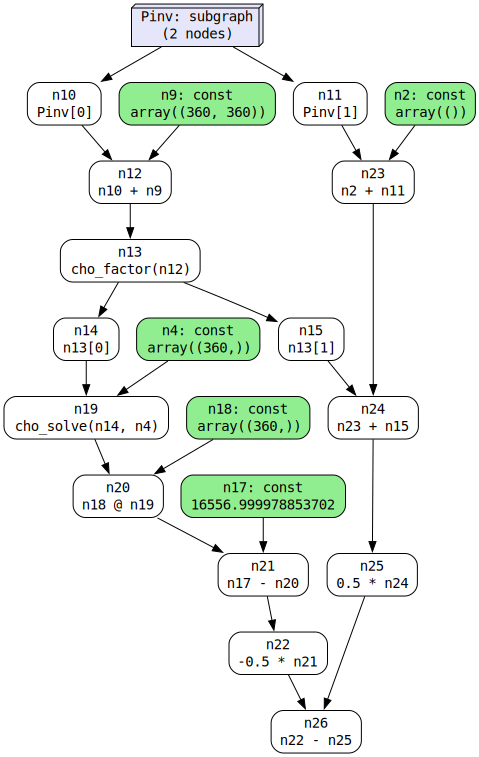

In [161]:
mm.visualize_graph(mm.fold_constants(onewood))

In [838]:
mm.func(onewood)(params = ds.sample_uniform(mm.func(onewood).params))

Array(98559.39376412, dtype=float64)

## Discovery likelihood

#### Measurement noise only

In [1426]:
# m = ds.PulsarLikelihood([psr.residuals,
#                          ds.makenoise_measurement_simple(psr)])

In [839]:
@mm.graph
def noisesolve(graph, y, N):
    result = N.solve(y)

In [840]:
@mm.graph
def noiseinv(graph, P):
    result = P.inv()

In [841]:
@mm.graph
def normal(g, y, Nsolve):
    Nmy, lN = Nsolve(y).split()
    logp = -0.5 * (y.T @ Nmy) - 0.5 * lN

In [842]:
class NoiseMatrix:
    def __init__(self, N):
        self.N = N

    @property
    def make_solve(self):
        return mm.func(noisesolve(None, self.N))    

    @property
    def make_inv(self):
        return mm.func(noiseinv(self.N))

In [843]:
ds.signals.matrix.NoiseMatrix1D_novar = NoiseMatrix
ds.signals.matrix.NoiseMatrix1D_var = NoiseMatrix

In [844]:
N = ds.makenoise_measurement(psr, noisedict=psr.noisedict)
graph = normal(psr.residuals, N.make_solve)

In [845]:
mm.print_graph(mm.prune_graph(mm.fold_constants(graph)))

n7: const = array(shape=(), dtype=float64)


In [846]:
mm.func(graph)()

Array(96686.81011374, dtype=float64)

In [847]:
N = ds.makenoise_measurement(psr)
graph = normal(psr.residuals, N.make_solve)

In [848]:
N.make_solve.params

['B1855+09_430_ASP_efac',
 'B1855+09_430_ASP_log10_t2equad',
 'B1855+09_430_PUPPI_efac',
 'B1855+09_430_PUPPI_log10_t2equad',
 'B1855+09_L-wide_ASP_efac',
 'B1855+09_L-wide_ASP_log10_t2equad',
 'B1855+09_L-wide_PUPPI_efac',
 'B1855+09_L-wide_PUPPI_log10_t2equad']

In [849]:
mm.print_graph(mm.prune_graph(mm.fold_constants(graph)))

y: const = array(shape=(7758,), dtype=float64)
Nsolve: func = <PjitFunction of <function build_callable_from_graph.<locals>.f at 0x43712e980>>
n0: node(Nsolve, y) = Nsolve(y)
n1: node(n0) = split(n0)[0]
n2: node(n0) = split(n0)[1]
n3: const = array(shape=(7758,), dtype=float64)
n4: node(n3, n1) = n3 @ n1
n5: node(n4) = -0.5 * n4
n6: node(n2) = 0.5 * n2
n7: node(n5, n6) = n5 - n6


In [850]:
mm.func(graph).params

['B1855+09_430_ASP_efac',
 'B1855+09_430_ASP_log10_t2equad',
 'B1855+09_430_PUPPI_efac',
 'B1855+09_430_PUPPI_log10_t2equad',
 'B1855+09_L-wide_ASP_efac',
 'B1855+09_L-wide_ASP_log10_t2equad',
 'B1855+09_L-wide_PUPPI_efac',
 'B1855+09_L-wide_PUPPI_log10_t2equad']

In [851]:
mm.func(graph)(params=ds.sample_uniform(mm.func(graph).params))

Array(90546.10232252, dtype=float64)

#### Add ECORR noise

In [852]:
# m = ds.PulsarLikelihood([psr.residuals,
#                          ds.makenoise_measurement(psr),
#                          ds.makegp_ecorr(psr)])

In [853]:
@mm.graph
def woodbury(g, y, Nsolve, F, Pinv):
    Nmy, lN = Nsolve(y)
    FtNmy = F.T @ Nmy

    NmF, _ = Nsolve(F)    
    FtNmF = F.T @ NmF

    Pm, lP = Pinv
    cf, lS = g.factor(Pm + FtNmF)

    logp = -0.5 * (y.T @ Nmy - FtNmy.T @ cf(FtNmy)) - 0.5 * (lN + lP + lS)

In [854]:
N = ds.makenoise_measurement(psr, noisedict=psr.noisedict)
graph = normal(psr.residuals, N.make_solve)

In [855]:
N = ds.makenoise_measurement(psr, noisedict=psr.noisedict)
egp = ds.makegp_ecorr(psr)
graph = woodbury(psr.residuals, N.make_solve, egp.F, egp.Phi.make_inv)

In [856]:
mm.print_graph(mm.prune_graph(mm.fold_constants(graph)))

Pinv: func = <PjitFunction of <function build_callable_from_graph.<locals>.f at 0x3ea6814e0>>
n2: const = array(shape=(), dtype=float64)
n4: const = array(shape=(360,), dtype=float64)
n9: const = array(shape=(360, 360), dtype=float64)
n10: node(Pinv) = Pinv[0]
n11: node(Pinv) = Pinv[1]
n12: node(n10, n9) = n10 + n9
n13: node(n12) = <function cholesky_factor at 0x393043ce0>
n14: node(n13) = n13[0]
n15: node(n13) = n13[1]
n17: const = array(shape=(), dtype=float64)
n18: const = array(shape=(360,), dtype=float64)
n19: node(n14, n4) = n14(n4)
n20: node(n18, n19) = n18 @ n19
n21: node(n17, n20) = n17 - n20
n22: node(n21) = -0.5 * n21
n23: node(n2, n11) = n2 + n11
n24: node(n23, n15) = n23 + n15
n25: node(n24) = 0.5 * n24
n26: node(n22, n25) = n22 - n25


In [857]:
mm.func(graph).params

['B1855+09_430_ASP_log10_ecorr',
 'B1855+09_430_PUPPI_log10_ecorr',
 'B1855+09_L-wide_ASP_log10_ecorr',
 'B1855+09_L-wide_PUPPI_log10_ecorr']

In [858]:
mm.func(graph)(params=ds.sample_uniform(mm.func(graph).params))

Array(96796.92856542, dtype=float64)

#### Constant GP + variable GP

In [859]:
# m = ds.PulsarLikelihood([psr.residuals,
#                          ds.makenoise_measurement(psr, psr.noisedict),
#                          ds.makegp_timing(psr, svd=True),
#                          ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')])

In [860]:
importlib.reload(mm)

<module 'discovery.metamatrix' from '/Users/vallis/Documents/discovery/src/discovery/metamatrix.py'>

In [861]:
@mm.graph
def woodburysolve(g, y, Nsolve, F, Pinv):
    Nmy, lN = Nsolve(y)
    FtNmy = F.T @ Nmy

    NmF, _ = Nsolve(F)
    FtNmF = F.T @ NmF

    Pm, lP = Pinv
    cf, lS = g.factor(Pm + FtNmF)

    solve = Nmy - NmF @ cf(FtNmy)
    ld = lN + lP + lS

    result = g.pair(solve, ld)

In [862]:
N = ds.makenoise_measurement(psr, noisedict=psr.noisedict)
tgp = ds.makegp_timing(psr, svd=True)
rgp = ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')

In [863]:
graph1 = woodburysolve(None, N.make_solve, tgp.F, tgp.Phi.make_inv)

In [864]:
mm.print_graph(mm.prune_graph(mm.fold_constants(graph1)))

y: arg
Nsolve: func = <PjitFunction of <function build_callable_from_graph.<locals>.f at 0x4370cd620>>
n0: node(Nsolve, y) = Nsolve(y)
n1: node(n0) = n0[0]
n2: node(n0) = n0[1]
n3: const = array(shape=(166, 7758), dtype=float64)
n4: node(n3, n1) = n3 @ n1
n6: const = array(shape=(7758, 166), dtype=float64)
n11: const = array(shape=(), dtype=float64)
n14: const = <function cholesky_factor.<locals>.solver at 0x447864d60>
n15: const = array(shape=(), dtype=float64)
n16: node(n14, n4) = n14(n4)
n17: node(n6, n16) = n6 @ n16
n18: node(n1, n17) = n1 - n17
n19: node(n2, n11) = n2 + n11
n20: node(n19, n15) = n19 + n15
n21: node(n18, n20) = <function GraphBuilder.pair.<locals>.<lambda> at 0x43342c900>


In [865]:
graph2 = woodbury(yvec, mm.func(graph1), rgp.F, rgp.Phi.make_inv)

In [866]:
mm.print_graph(mm.prune_graph(mm.fold_constants(graph2)))

Pinv: func = <PjitFunction of <function build_callable_from_graph.<locals>.f at 0x395d5d080>>
n2: const = array(shape=(), dtype=float64)
n4: const = array(shape=(60,), dtype=float64)
n9: const = array(shape=(60, 60), dtype=float64)
n10: node(Pinv) = Pinv[0]
n11: node(Pinv) = Pinv[1]
n12: node(n10, n9) = n10 + n9
n13: node(n12) = <function cholesky_factor at 0x38e0940e0>
n14: node(n13) = n13[0]
n15: node(n13) = n13[1]
n17: const = array(shape=(), dtype=float64)
n18: const = array(shape=(60,), dtype=float64)
n19: node(n14, n4) = n14(n4)
n20: node(n18, n19) = n18 @ n19
n21: node(n17, n20) = n17 - n20
n22: node(n21) = -0.5 * n21
n23: node(n2, n11) = n2 + n11
n24: node(n23, n15) = n23 + n15
n25: node(n24) = 0.5 * n24
n26: node(n22, n25) = n22 - n25


In [867]:
mm.func(graph2).params

['B1855+09_rednoise_gamma', 'B1855+09_rednoise_log10_A']

In [868]:
mm.func(graph2)(params=ds.sample_uniform(mm.func(graph2).params))

Array(89903.63134199, dtype=float64)

### Full single likelihood

In [869]:
# m = ds.PulsarLikelihood([psr.residuals,
#                          ds.makenoise_measurement(psr, psr.noisedict),
#                          ds.makegp_ecorr(psr, psr.noisedict),
#                          ds.makegp_timing(psr, svd=True),
#                          ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')])

In [871]:
@mm.graph
def concat(g, a, b):
    result = g.node(lambda x, y: jnp.hstack([x, y]), [a, b])

In [872]:
import functools

class CompoundGP:
    def __init__(self, gplist):
        self.gplist = gplist

    @property
    def F(self):
        return functools.reduce(lambda x, y: mm.func(concat(x, y)), [gp.F for gp in self.gplist])
    
    @property
    def Phi(self):
        # won't work for 2D priors
        N = functools.reduce(lambda x, y: mm.func(concat(x, y)), [gp.Phi.N for gp in self.gplist]) 
        return NoiseMatrix(N)

In [873]:
@mm.graph
def delay(g, y, d):
    result = y - d

In [874]:
def CompoundDelay(residuals, delays):
    return functools.reduce(lambda x, y: mm.func(delay(x, y)), [residuals, *delays])

#### Clean example

In [875]:
N = ds.makenoise_measurement(psr, noisedict=psr.noisedict)

egp = ds.makegp_ecorr(psr, noisedict=psr.noisedict)
tgp = ds.makegp_timing(psr, svd=True)
cgp = CompoundGP([egp, tgp])

graph1 = woodburysolve(None, N.make_solve, cgp.F, cgp.Phi.make_inv)

cwcommon = ['cw_sindec', 'cw_cosinc', 'cw_log10_f0', 'cw_log10_h0', 'cw_phi_earth', 'cw_psi', 'cw_ra']
yd = CompoundDelay(yvec, [ds.makedelay(psr, ds.makedelay_binary(pulsarterm=True), common=cwcommon, name='cw')])

rgp = ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')

graph2 = woodbury(yd, mm.func(graph1), rgp.F, rgp.Phi.make_inv)

logp = mm.func(graph2)

In [876]:
mm.print_graph(graph2, simplify=True)

y: func = <PjitFunction of <function build_callable_from_graph.<locals>.f at 0x4370cc400>>
Nsolve: func = <PjitFunction of <function build_callable_from_graph.<locals>.f at 0x447ee3ba0>>
Pinv: func = <PjitFunction of <function build_callable_from_graph.<locals>.f at 0x447ee3920>>
n0: node(Nsolve, y) = Nsolve(y)
n1: node(n0) = n0[0]
n2: node(n0) = n0[1]
n3: const = array(shape=(60, 7758), dtype=float64)
n4: node(n3, n1) = n3 @ n1
n9: const = array(shape=(60, 60), dtype=float64)
n10: node(Pinv) = Pinv[0]
n11: node(Pinv) = Pinv[1]
n12: node(n10, n9) = n10 + n9
n13: node(n12) = <function cholesky_factor at 0x383a177e0>
n14: node(n13) = n13[0]
n15: node(n13) = n13[1]
n16: node(y) = <function Sym.T.<locals>.<lambda> at 0x447ef8e00>
n17: node(n16, n1) = n16 @ n1
n18: node(n4) = <function Sym.T.<locals>.<lambda> at 0x447ef8f40>
n19: node(n14, n4) = n14(n4)
n20: node(n18, n19) = n18 @ n19
n21: node(n17, n20) = n17 - n20
n22: node(n21) = -0.5 * n21
n23: node(n2, n11) = n2 + n11
n24: node(n23, n1

In [877]:
p0 = ds.sample_uniform(logp.params)

In [878]:
p0

{'B1855+09_cw_phi_psr': 1.411928033421281,
 'B1855+09_rednoise_gamma': 0.3375543574402363,
 'B1855+09_rednoise_log10_A': -15.03119920193601,
 'cw_cosinc': 0.5033299616673554,
 'cw_log10_f0': -8.499182894688783,
 'cw_log10_h0': -14.928982381721593,
 'cw_phi_earth': 6.023302048435835,
 'cw_psi': 0.14147652042076786,
 'cw_ra': 0.9348743543830029,
 'cw_sindec': -0.4938450071370477}

In [879]:
logp(params=ds.sample_uniform(p0))

Array(76806.82934148, dtype=float64)

## Standard tests

In [436]:
import discovery.metamatrix as mm
import discovery.metamath as mh

(For debugging)

In [607]:
importlib.reload(mm)
importlib.reload(mh)
importlib.reload(ds.likelihood)
importlib.reload(ds)

mm.keepgraph = True

Monkey patching

In [608]:
ds.matrix.NoiseMatrix1D_novar = mh.NoiseMatrix
ds.matrix.NoiseMatrix1D_var = mh.NoiseMatrix
ds.matrix.NoiseMatrix2D_var = mh.NoiseMatrix

ds.matrix.WoodburyKernel = mh.WoodburyKernel
ds.matrix.CompoundGP = mh.CompoundGP
ds.matrix.CompoundDelay = mh.CompoundDelay

ds.matrix.VectorNoiseMatrix1D_var = mh.NoiseMatrix
ds.matrix.VectorWoodburyKernel_varP = mh.VectorWoodburyKernel
ds.matrix.VectorCompoundGP = mh.CompoundGP

### Single pulsar likelihood

#### Measurement noise only, no backends

In [253]:
m = ds.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement_simple(psr)])

In [254]:
m.logL, m.logL.params

(<function discovery.likelihood.ffunc.<locals>.outfunc(params)>,
 ['B1855+09_efac', 'B1855+09_log10_t2equad'])

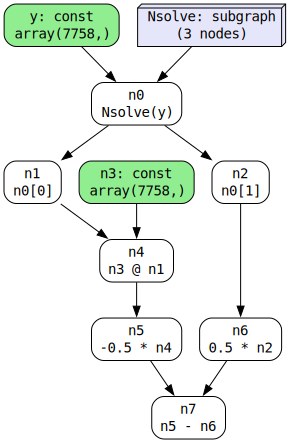

In [255]:
mm.visualize_graph(m.logL.graph)

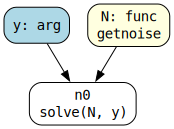

In [256]:
mm.visualize_graph(m.logL.graph.subgraphs[0])

What are the active parameters?

In [257]:
m.logL.params

['B1855+09_efac', 'B1855+09_log10_t2equad']

Sample random values from their priors

In [258]:
p0 = ds.sample_uniform(m.logL.params); p0

{'B1855+09_efac': 1.027590955615459,
 'B1855+09_log10_t2equad': -5.778885297371488}

Evaluate the likelihood

In [259]:
m.logL(p0)

Array(97690.47624786, dtype=float64)

Try compiled version, grad

In [260]:
jax.jit(m.logL)(p0)

Array(97690.47624786, dtype=float64)

In [261]:
jax.grad(m.logL)(p0)

{'B1855+09_efac': Array(-2880.01134487, dtype=float64, weak_type=True),
 'B1855+09_log10_t2equad': Array(-5644.79316975, dtype=float64, weak_type=True)}

#### Measurement noise only, nanograv backends, free parameters

In [262]:
m = ds.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement(psr)])

In [263]:
m.logL.params

['B1855+09_430_ASP_efac',
 'B1855+09_430_ASP_log10_t2equad',
 'B1855+09_430_PUPPI_efac',
 'B1855+09_430_PUPPI_log10_t2equad',
 'B1855+09_L-wide_ASP_efac',
 'B1855+09_L-wide_ASP_log10_t2equad',
 'B1855+09_L-wide_PUPPI_efac',
 'B1855+09_L-wide_PUPPI_log10_t2equad']

In [264]:
p0 = ds.sample_uniform(m.logL.params)

In [265]:
m.logL(p0)

Array(91590.50758825, dtype=float64)

#### Measurement noise only, nanograv backends, parameters from noisedict

In [266]:
psr.noisedict

{'B1855+09_430_ASP_efac': 1.115935306813982,
 'B1855+09_430_ASP_log10_t2equad': -7.564164330699591,
 'B1855+09_430_PUPPI_efac': 1.000049037085653,
 'B1855+09_430_PUPPI_log10_t2equad': -6.572540211467256,
 'B1855+09_L-wide_ASP_efac': 1.043114017270374,
 'B1855+09_L-wide_ASP_log10_t2equad': -6.517929916655293,
 'B1855+09_L-wide_PUPPI_efac': 1.1118432332882,
 'B1855+09_L-wide_PUPPI_log10_t2equad': -7.755603780476984,
 'B1855+09_430_ASP_log10_ecorr': -6.798122106550257,
 'B1855+09_430_PUPPI_log10_ecorr': -5.6989064141929715,
 'B1855+09_L-wide_ASP_log10_ecorr': -6.120457109433745,
 'B1855+09_L-wide_PUPPI_log10_ecorr': -6.641667916624413,
 'B1855+09_red_noise_log10_A': -13.940953818371378,
 'B1855+09_red_noise_gamma': -3.68432133461766}

In [267]:
m = ds.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement(psr, psr.noisedict)])

In [268]:
m.logL.params

[]

In [269]:
m.logL({})

Array(96686.81011374, dtype=float64)

In [270]:
jax.jit(m.logL)({}), jax.jit(jax.grad(m.logL))({})

(Array(96686.81011374, dtype=float64), {})

#### Add ECORR noise (GP), free params

In [330]:
m = ds.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement(psr),
                         ds.makegp_ecorr(psr)])

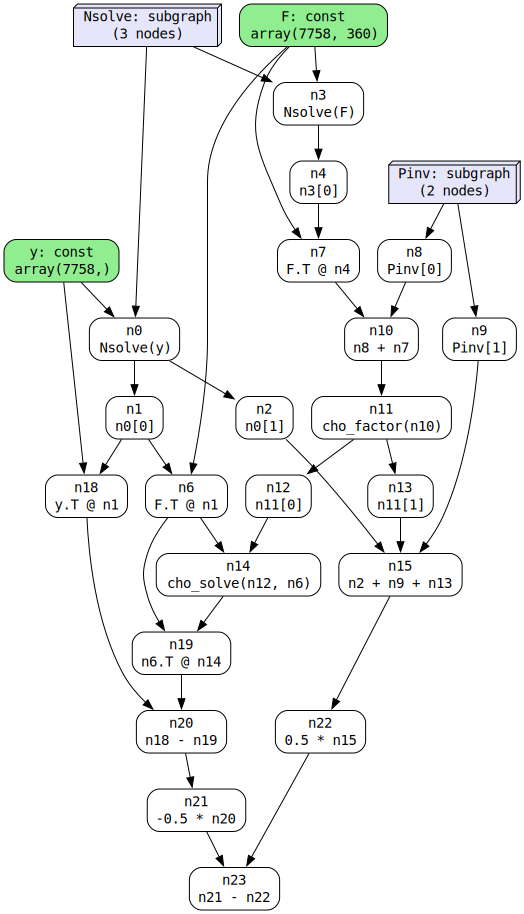

In [336]:
mm.visualize_graph(m.logL.graph)

In [333]:
m.logL.params

['B1855+09_430_ASP_efac',
 'B1855+09_430_ASP_log10_ecorr',
 'B1855+09_430_ASP_log10_t2equad',
 'B1855+09_430_PUPPI_efac',
 'B1855+09_430_PUPPI_log10_ecorr',
 'B1855+09_430_PUPPI_log10_t2equad',
 'B1855+09_L-wide_ASP_efac',
 'B1855+09_L-wide_ASP_log10_ecorr',
 'B1855+09_L-wide_ASP_log10_t2equad',
 'B1855+09_L-wide_PUPPI_efac',
 'B1855+09_L-wide_PUPPI_log10_ecorr',
 'B1855+09_L-wide_PUPPI_log10_t2equad']

In [334]:
p0 = ds.sample_uniform(m.logL.params)

In [335]:
m.logL(p0)

Array(98145.54624178, dtype=float64)

In [337]:
jax.jit(m.logL)(p0), jax.jit(jax.grad(m.logL))(p0)

(Array(98145.54624178, dtype=float64),
 {'B1855+09_430_ASP_efac': Array(408.07954497, dtype=float64, weak_type=True),
  'B1855+09_430_ASP_log10_ecorr': Array(0.59242938, dtype=float64, weak_type=True),
  'B1855+09_430_ASP_log10_t2equad': Array(0.30466074, dtype=float64, weak_type=True),
  'B1855+09_430_PUPPI_efac': Array(17.53511797, dtype=float64, weak_type=True),
  'B1855+09_430_PUPPI_log10_ecorr': Array(-189.32680846, dtype=float64, weak_type=True),
  'B1855+09_430_PUPPI_log10_t2equad': Array(0.03237228, dtype=float64, weak_type=True),
  'B1855+09_L-wide_ASP_efac': Array(-905.39482444, dtype=float64, weak_type=True),
  'B1855+09_L-wide_ASP_log10_ecorr': Array(-106.18952673, dtype=float64, weak_type=True),
  'B1855+09_L-wide_ASP_log10_t2equad': Array(-1838.04482486, dtype=float64, weak_type=True),
  'B1855+09_L-wide_PUPPI_efac': Array(2244.61399869, dtype=float64, weak_type=True),
  'B1855+09_L-wide_PUPPI_log10_ecorr': Array(1538.20930538, dtype=float64, weak_type=True),
  'B1855+09_

#### Add ECORR noise (GP), noisedict params

In [338]:
m = ds.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement(psr, psr.noisedict),
                         ds.makegp_ecorr(psr, psr.noisedict)])

In [339]:
m.logL.params

[]

In [340]:
m.logL({})

Array(100267.11920383, dtype=float64)

In [341]:
jax.jit(m.logL)({}), jax.jit(jax.grad(m.logL))({})

(Array(100267.11920383, dtype=float64), {})

#### Add timing model

In [342]:
m = ds.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement(psr, psr.noisedict),
                         ds.makegp_ecorr(psr, psr.noisedict),
                         ds.makegp_timing(psr, svd=True)])

In [343]:
m.logL.params

[]

In [344]:
m.logL({})

Array(90998.49655392, dtype=float64)

In [345]:
jax.jit(m.logL)({}), jax.jit(jax.grad(m.logL))({})

(Array(90998.49655392, dtype=float64), {})

#### Add red noise (powerlaw)

In [353]:
m = ds.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement(psr, psr.noisedict),
                         ds.makegp_ecorr(psr, psr.noisedict),
                         ds.makegp_timing(psr, svd=True),
                         ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')])

In [354]:
m.logL.params

['B1855+09_rednoise_gamma', 'B1855+09_rednoise_log10_A']

In [355]:
mm.print_graph(m.logL.graph)

## graph
Pinv: graph = subgraph Pinv[159b]
n2: const = array()
n6: const = array(60,)
n7: const = array(60, 60)
n8: node(Pinv) = Pinv[0]
n9: node(Pinv) = Pinv[1]
n10: node(n8, n7) = n8 + n7
n11: node(n10) = cho_factor(n10)
n12: node(n11) = n11[0]
n13: node(n11) = n11[1]
n14: node(n12, n6) = cho_solve(n12, n6)
n15: node(n2, n9, n13) = n2 + n9 + n13
n18: const = array()
n19: node(n6, n14) = n6.T @ n14
n20: node(n18, n19) = n18 - n19
n21: node(n20) = -0.5 * n20
n22: node(n15) = 0.5 * n15
n23: node(n21, n22) = n21 - n22
# total array constants: 3662 elements

## subgraph Pinv[159b]
P: func = <function makegp_fourier.<locals>.priorfunc at 0x403f70180>
n0: node(P) = inv(P)
# total array constants: 0 elements


3662

In [357]:
p0 = ds.sample_uniform(m.logL.params)

In [358]:
m.logL(p0)

Array(91002.10181449, dtype=float64)

In [359]:
m.logL.params

['B1855+09_rednoise_gamma', 'B1855+09_rednoise_log10_A']

In [360]:
jlogl = jax.jit(m.logL)

In [361]:
jlogl(p0), jax.jit(jax.grad(m.logL))(p0)

(Array(91002.10181449, dtype=float64),
 {'B1855+09_rednoise_gamma': Array(-11.43520735, dtype=float64, weak_type=True),
  'B1855+09_rednoise_log10_A': Array(-80.46924955, dtype=float64, weak_type=True)})

In [362]:
%timeit jlogl(p0).block_until_ready()

28.8 μs ± 278 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


#### Add red noise (powerlaw, fixed gamma)

In [576]:
m = ds.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement(psr, psr.noisedict),
                         ds.makegp_ecorr(psr, psr.noisedict),
                         ds.makegp_timing(psr, svd=True),
                         ds.makegp_fourier(psr, ds.partial(ds.powerlaw, gamma=4.33), components=30, name='rednoise')])

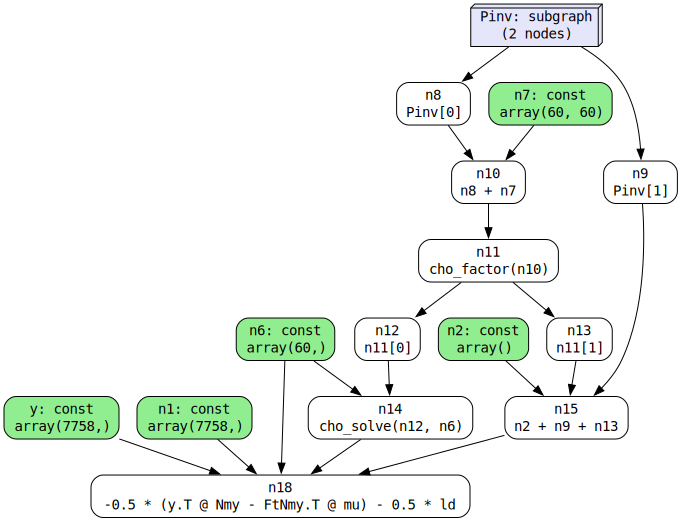

In [577]:
mm.visualize_graph(m.logL.graph)

In [578]:
m.logL.params

['B1855+09_rednoise_log10_A']

In [579]:
p0 = ds.sample_uniform(m.logL.params)

In [580]:
m.logL(p0)

Array(90998.51283427, dtype=float64)

In [581]:
jax.jit(m.logL)(p0), jax.jit(jax.grad(m.logL))(p0)

(Array(90998.51283427, dtype=float64),
 {'B1855+09_rednoise_log10_A': Array(0.07495666, dtype=float64, weak_type=True)})

In [582]:
mm.print_graph(m.logL.graph)

## graph
y: const = array(7758,)
Pinv: graph = subgraph Pinv[ff97]
n1: const = array(7758,)
n2: const = array()
n6: const = array(60,)
n7: const = array(60, 60)
n8: node(Pinv) = Pinv[0]
n9: node(Pinv) = Pinv[1]
n10: node(n8, n7) = n8 + n7
n11: node(n10) = cho_factor(n10)
n12: node(n11) = n11[0]
n13: node(n11) = n11[1]
n14: node(n12, n6) = cho_solve(n12, n6)
n15: node(n2, n9, n13) = n2 + n9 + n13
n18: node(y, n1, n6, n14, n15) = -0.5 * (y.T @ Nmy - FtNmy.T @ mu) - 0.5 * ld
# total array constants: 19177 elements

## subgraph Pinv[ff97]
P: func = <function makegp_fourier.<locals>.priorfunc at 0x4990d00e0>
n0: node(P) = inv(P)
# total array constants: 0 elements


19177

Try out `sample_conditional`, obtained by a shortening of the `woodbury` graph.

In [583]:
cond = m.conditional

In [584]:
cond(p0)

(Array([-1.77804986e-10, -1.41074335e-10, -8.38470596e-12, -8.08886276e-12,
        -1.78327879e-12,  9.85685900e-13, -9.86370399e-14,  2.48484355e-13,
        -3.17940069e-14, -2.23084662e-14, -2.89139836e-16,  5.47452437e-14,
         2.02940396e-14,  3.59660137e-15, -2.49817490e-15, -2.76577572e-15,
        -3.14438249e-15,  4.56549719e-15, -8.17065807e-16,  8.66574679e-16,
        -9.04720741e-16,  5.21147161e-16, -2.34931414e-17,  9.46993485e-16,
         2.29469514e-16,  9.95597998e-17,  7.18295609e-17,  4.40379175e-16,
        -2.56867415e-17, -2.57788551e-16,  1.10664571e-16, -9.17768601e-17,
         2.16631171e-16, -1.66352935e-17,  2.92673337e-18, -1.67004461e-16,
         5.58163930e-17,  2.34098543e-16,  6.29262750e-17,  1.56788353e-16,
        -5.54250905e-17,  1.44581018e-16,  6.98376671e-17,  1.31787780e-16,
         5.98198402e-17,  6.23132672e-18,  2.61995645e-17,  2.62285092e-18,
         4.38299929e-17, -3.70968316e-17, -3.48729511e-18, -3.98423748e-17,
        -1.5

In [585]:
scond = m.sample_conditional

In [586]:
scond(jax.random.PRNGKey(0), p0)

(Array([4146024105,  967050713], dtype=uint32),
 {'B1855+09_rednoise_coefficients(60)': Array([-9.02734444e-10, -1.59555048e-09, -1.10547529e-10, -2.33068578e-10,
          1.38890837e-10, -3.05302899e-11,  7.96270861e-12, -8.70623262e-11,
         -1.40611213e-11,  2.47156714e-11, -1.50876073e-11,  3.25353307e-11,
          8.54145047e-12,  2.72591942e-11, -1.20035908e-11, -1.38215262e-11,
          3.01029245e-12, -5.59086513e-12, -3.14580278e-12,  1.85687533e-11,
         -1.74516783e-11, -2.25789599e-12, -4.77369049e-12, -1.61164795e-12,
         -2.53977523e-12,  2.43485523e-12, -3.25165153e-12,  5.72974566e-12,
         -7.43820749e-13,  4.45748736e-13,  4.88239916e-12,  2.95844920e-12,
         -4.86411028e-13, -1.64280734e-13, -1.46039166e-12, -6.25406047e-13,
         -9.02606628e-13,  1.94046864e-12,  1.02677060e-12, -3.09647704e-13,
          7.12800518e-14, -2.46228426e-12,  3.81357532e-12,  1.87682088e-13,
         -3.79408341e-12,  6.21562095e-13, -4.09377346e-12,  6.9041

Coefficient likelihood

In [587]:
clogl = m.clogL

In [588]:
clogl.params

['B1855+09_rednoise_coefficients(60)', 'B1855+09_rednoise_log10_A']

In [597]:
mm.print_graph(clogl.graph)

## graph
y: const = array(7758,)
Nsolve: graph = subgraph Nsolve[ce00]
F: const = array(7758, 60)
Psolve: graph = subgraph Psolve[3611]
getc: func = <function WoodburyKernel.make_coefficientproduct.<locals>.getc at 0x425742340>
n0: node(F, getc) = F @ getc
n1: node(y, n0) = y - n0
n2: node(Nsolve, n1) = Nsolve(n1)
n3: node(n2) = n2[0]
n4: node(n2) = n2[1]
n5: node(Psolve, getc) = Psolve(getc)
n6: node(n5) = n5[0]
n7: node(n5) = n5[1]
n8: node(n1) = n1.T
n9: node(n8, n3) = n8 @ n3
n10: node(getc) = getc.T
n11: node(n10, n6) = n10 @ n6
n12: node(n9, n11) = n9 + n11
n13: node(n12, n7) = n12 + n7
n14: node(n13, n4) = n13 + n4
n15: node(n14) = -0.5 * n14
# total array constants: 473238 elements

## subgraph Nsolve[ce00]
y: arg
Nsolve: graph = subgraph Nsolve[239b]
n0: node(Nsolve, y) = Nsolve(y)
n1: node(n0) = n0[0]
n2: node(n0) = n0[1]
n4: const = array(7758, 526)
n6: node(n4, y) = n4.T @ y
n9: const = array()
n12: const = array(526, 526), True
n13: const = array()
n14: node(n12, n6) = cho

4838382

In [598]:
clogl({**p0, **scond(jax.random.PRNGKey(0), p0)[1]})

Array(92517.58721755, dtype=float64)

#### Add red noise (free spectrum)

In [609]:
m = ds.PulsarLikelihood([psr.residuals,
                         ds.makenoise_measurement(psr, psr.noisedict),
                         ds.makegp_ecorr(psr, psr.noisedict),
                         ds.makegp_timing(psr, svd=True),
                         ds.makegp_fourier(psr, ds.freespectrum, components=30, name='rednoise')])

In [610]:
m.logL.params

['B1855+09_rednoise_log10_rho(30)']

In [611]:
p0 = {'B1855+09_rednoise_log10_rho(30)': 1e-6 * np.random.randn(30)}

In [612]:
m.logL(p0)

Array(90205.41583854, dtype=float64)

In [613]:
mm.print_graph(m.logL.graph, fold=True)

## graph
Pinv: graph = subgraph Pinv[ca03]
n2: const = array()
n6: const = array(60,)
n7: const = array(60, 60)
n8: node(Pinv) = Pinv[0]
n9: node(Pinv) = Pinv[1]
n10: node(n8, n7) = n8 + n7
n11: node(n10) = cho_factor(n10)
n12: node(n11) = n11[0]
n13: node(n11) = n11[1]
n14: node(n12, n6) = cho_solve(n12, n6)
n15: node(n2, n9, n13) = n2 + n9 + n13
n18: const = array()
n19: node(n6, n14) = n6.T @ n14
n20: node(n18, n19) = n18 - n19
n21: node(n20) = -0.5 * n20
n22: node(n15) = 0.5 * n15
n23: node(n21, n22) = n21 - n22
# total array constants: 3662 elements

## subgraph Pinv[ca03]
P: func = <function makegp_fourier.<locals>.priorfunc at 0x498d82ac0>
n0: node(P) = inv(P)
# total array constants: 0 elements


3662

In [614]:
jax.jit(m.logL)(p0), jax.jit(jax.grad(m.logL))(p0)

(Array(90205.41583854, dtype=float64),
 {'B1855+09_rednoise_log10_rho(30)': Array([-4.60516845, -4.60517007, -4.60517016, -4.60517018, -4.60517018,
         -4.60517018, -4.60517018, -4.60517018, -4.60517018, -4.60517018,
         -4.60517018, -4.60517018, -4.60517019, -4.60517018, -4.60517014,
         -4.60517013, -4.60517019, -4.60517019, -4.60517019, -4.60517019,
         -4.60517019, -4.60517019, -4.60517019, -4.60517019, -4.60517019,
         -4.60517019, -4.60517019, -4.60517019, -4.60517019, -4.60517019],      dtype=float64)})

### Multiple pulsars

In [163]:
psrs = allpsrs[:3]

#### Combined likelihood

In [184]:
m = ds.ArrayLikelihood([ds.PulsarLikelihood([psr.residuals,
                                             ds.makenoise_measurement(psr, psr.noisedict),
                                             ds.makegp_ecorr(psr, psr.noisedict),
                                             ds.makegp_timing(psr, svd=True),
                                             ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')])
                        for psr in psrs])

In [185]:
m.logL.params

['B1855+09_rednoise_gamma',
 'B1855+09_rednoise_log10_A',
 'B1937+21_rednoise_gamma',
 'B1937+21_rednoise_log10_A',
 'B1953+29_rednoise_gamma',
 'B1953+29_rednoise_log10_A']

In [186]:
for graph in m.logL.graphs:
    mm.print_graph(graph); print('', end='\n')

Pinv: func = subgraph
n2: const = array(shape=(), dtype=float64)
n7: const = array(shape=(60,), dtype=float64)
n9: const = array(shape=(60, 60), dtype=float64)
n10: node(Pinv) = Pinv[0]
n11: node(Pinv) = Pinv[1]
n12: node(n10, n9) = n10 + n9
n13: node(n12) = <function GraphBuilder.cho_factor.<locals>.<lambda> at 0x46973b2e0>
n14: node(n13) = n13[0]
n15: node(n13) = n13[1]
n16: node(n14, n7) = <function GraphBuilder.cho_solve.<locals>.<lambda> at 0x308ae8fe0>
n17: node(n2, n11) = n2 + n11
n18: node(n17, n15) = n17 + n15
n22: const = array(shape=(), dtype=float64)
n23: const = array(shape=(60,), dtype=float64)
n24: node(n23, n16) = n23 @ n16
n25: node(n22, n24) = n22 - n24
n26: node(n25) = -0.5 * n25
n27: node(n18) = 0.5 * n18
n28: node(n26, n27) = n26 - n27
total constants: 3722 elements

subgraph Pinv
P: func = <function makegp_fourier.<locals>.priorfunc at 0x4619d4e00>
n0: node(P) = inv(P)
total constants: 0 elements

Pinv: func = subgraph
n2: const = array(shape=(), dtype=float64)
n7

In [1539]:
p0 = ds.sample_uniform(m.logL.params)

In [1540]:
m.logL(p0)

Array(428750.37465291, dtype=float64)

In [1541]:
jax.jit(m.logL)(p0), jax.jit(jax.grad(m.logL))(p0)

(Array(428750.37465291, dtype=float64),
 {'B1855+09_rednoise_gamma': Array(3.05345424e-06, dtype=float64, weak_type=True),
  'B1855+09_rednoise_log10_A': Array(5.86463577e-06, dtype=float64, weak_type=True),
  'B1937+21_rednoise_gamma': Array(202.90465454, dtype=float64, weak_type=True),
  'B1937+21_rednoise_log10_A': Array(352.76828802, dtype=float64, weak_type=True),
  'B1953+29_rednoise_gamma': Array(3.27125155e-08, dtype=float64, weak_type=True),
  'B1953+29_rednoise_log10_A': Array(6.96815316e-08, dtype=float64, weak_type=True)})

#### Add common noise

Indicating parameters under common shares them among pulsars

In [209]:
T = ds.getspan(psrs)

In [210]:
m = ds.ArrayLikelihood([ds.PulsarLikelihood([psr.residuals,
                                             ds.makenoise_measurement(psr, psr.noisedict),
                                             ds.makegp_ecorr(psr, psr.noisedict),
                                             ds.makegp_timing(psr, svd=True),
                                             ds.makegp_fourier(psr, ds.powerlaw, components=30, T=T, name='rednoise'),
                                             ds.makegp_fourier(psr, ds.powerlaw, components=14, T=T, name='crn',
                                                               common=['crn_log10_A', 'crn_gamma'])])
                        for psr in psrs])

In [211]:
m.logL.params

['B1855+09_rednoise_gamma',
 'B1855+09_rednoise_log10_A',
 'B1937+21_rednoise_gamma',
 'B1937+21_rednoise_log10_A',
 'B1953+29_rednoise_gamma',
 'B1953+29_rednoise_log10_A',
 'crn_gamma',
 'crn_log10_A']

In [212]:
for psr, graph in zip(psrs, m.logL.graphs):
    mm.print_graph(graph, name=psr.name); print('', end='\n')

## B1855+09
Pinv: func = subgraph
n2: const = array(shape=(), dtype=float64)
n7: const = array(shape=(88,), dtype=float64)
n9: const = array(shape=(88, 88), dtype=float64)
n10: node(Pinv) = Pinv[0]
n11: node(Pinv) = Pinv[1]
n12: node(n10, n9) = n10 + n9
n13: node(n12) = <function GraphBuilder.cho_factor.<locals>.<lambda> at 0x486dd07c0>
n14: node(n13) = n13[0]
n15: node(n13) = n13[1]
n16: node(n14, n7) = <function GraphBuilder.cho_solve.<locals>.<lambda> at 0x486bae3e0>
n17: node(n2, n11) = n2 + n11
n18: node(n17, n15) = n17 + n15
n22: const = array(shape=(), dtype=float64)
n23: const = array(shape=(88,), dtype=float64)
n24: node(n23, n16) = n23 @ n16
n25: node(n22, n24) = n22 - n24
n26: node(n25) = -0.5 * n25
n27: node(n18) = 0.5 * n18
n28: node(n26, n27) = n26 - n27
# total constants: 7922 elements

## subgraph Pinv
P: func = subgraph
n0: node(P) = inv(P)
# total constants: 0 elements

## subgraph P
a: func = <function makegp_fourier.<locals>.priorfunc at 0x308aeade0>
b: func = <func

In [40]:
p0 = ds.sample_uniform(m.logL.params); p0

{'B1855+09_rednoise_gamma': 0.1679496838571395,
 'B1855+09_rednoise_log10_A': -17.698611959842488,
 'B1937+21_rednoise_gamma': 0.00784949094073284,
 'B1937+21_rednoise_log10_A': -19.75020050091578,
 'B1953+29_rednoise_gamma': 1.2042736084017074,
 'B1953+29_rednoise_log10_A': -11.183608660453322,
 'crn_gamma': 1.8709309582488352,
 'crn_log10_A': -14.87337991721244}

In [41]:
m.logL(p0)

Array(446849.81918794, dtype=float64)

In [42]:
jax.jit(m.logL)(p0), jax.jit(jax.grad(m.logL))(p0)

(Array(446849.81918794, dtype=float64),
 {'B1855+09_rednoise_gamma': Array(1.93864881e-07, dtype=float64, weak_type=True),
  'B1855+09_rednoise_log10_A': Array(4.79749647e-07, dtype=float64, weak_type=True),
  'B1937+21_rednoise_gamma': Array(5.88279681e-08, dtype=float64, weak_type=True),
  'B1937+21_rednoise_log10_A': Array(1.64806801e-07, dtype=float64, weak_type=True),
  'B1953+29_rednoise_gamma': Array(-3.13782831, dtype=float64, weak_type=True),
  'B1953+29_rednoise_log10_A': Array(-69.11327102, dtype=float64, weak_type=True),
  'crn_gamma': Array(23486.65135904, dtype=float64, weak_type=True),
  'crn_log10_A': Array(45526.98798969, dtype=float64, weak_type=True)})

#### Parallelize red components

Coordinated timespan is required

In [214]:
m = ds.ArrayLikelihood([ds.PulsarLikelihood([psr.residuals,
                                             ds.makenoise_measurement(psr, psr.noisedict),
                                             ds.makegp_ecorr(psr, psr.noisedict),
                                             ds.makegp_timing(psr, svd=True)]) for psr in psrs],
                       commongp = [ds.makecommongp_fourier(psrs, ds.powerlaw, components=30, T=T, name='rednoise'),
                                   ds.makecommongp_fourier(psrs, ds.powerlaw, components=14, T=T, name='crn',
                                                           common=['crn_log10_A', 'crn_gamma'])])

In [215]:
m.logL.params

['B1855+09_rednoise_gamma',
 'B1855+09_rednoise_log10_A',
 'B1937+21_rednoise_gamma',
 'B1937+21_rednoise_log10_A',
 'B1953+29_rednoise_gamma',
 'B1953+29_rednoise_log10_A',
 'crn_gamma',
 'crn_log10_A']

In [217]:
mm.print_graph(m.logL.graph)

## graph
Pinv: func = subgraph
n39: const = array(shape=(), dtype=float64)
n40: const = array(shape=(3, 88), dtype=float64)
n41: const = array(shape=(3, 88, 88), dtype=float64)
n42: node(Pinv) = Pinv[0]
n43: node(Pinv) = Pinv[1]
n44: node(n42, n41) = n42 + n41
n45: node(n44) = <function GraphBuilder.cho_factor.<locals>.<lambda> at 0x486db53a0>
n46: node(n45) = n45[0]
n47: node(n45) = n45[1]
n48: node(n46, n40) = <function GraphBuilder.cho_solve.<locals>.<lambda> at 0x486db5800>
n49: node(n40, n48) = <function GraphBuilder.dot.<locals>.<lambda> at 0x486db5940>
n50: node(n39, n49) = n39 - n49
n51: node(n50) = -0.5 * n50
n52: node(n43) = sum(n43)
n53: node(n47) = sum(n47)
n54: node(n52, n53) = n52 + n53
n55: node(n54) = 0.5 * n54
n56: node(n51, n55) = n51 - n55
# total constants: 23497 elements

## subgraph Pinv
P: func = subgraph
n0: node(P) = inv(P)
# total constants: 0 elements

## subgraph P
a: func = <function makecommongp_fourier.<locals>.priorfunc at 0x308d65bc0>
b: func = <functio

In [1550]:
p0 = ds.sample_uniform(m.logL.params)

In [1551]:
m.logL(p0)

Array(470490.03854005, dtype=float64)

In [1552]:
jax.jit(m.logL)(p0), jax.jit(jax.grad(m.logL))(p0)

(Array(470490.03854005, dtype=float64),
 {'B1855+09_rednoise_gamma': Array(4.03474476e-11, dtype=float64, weak_type=True),
  'B1855+09_rednoise_log10_A': Array(8.68120657e-11, dtype=float64, weak_type=True),
  'B1937+21_rednoise_gamma': Array(3984.98505168, dtype=float64, weak_type=True),
  'B1937+21_rednoise_log10_A': Array(8385.50085979, dtype=float64, weak_type=True),
  'B1953+29_rednoise_gamma': Array(-6.2229804, dtype=float64, weak_type=True),
  'B1953+29_rednoise_log10_A': Array(-23.44628664, dtype=float64, weak_type=True),
  'crn_gamma': Array(823.2247943, dtype=float64, weak_type=True),
  'crn_log10_A': Array(1463.68196159, dtype=float64, weak_type=True)})

In [1553]:
cond = m.conditional

In [1554]:
cond(p0)

(Array([[ 6.09978291e-20, -1.84582810e-19,  1.07440468e-19,
          3.28605701e-20,  7.97036803e-20, -3.29151528e-20,
          5.34393124e-20,  7.99737864e-21, -9.67517288e-21,
          1.34498082e-20, -2.46207558e-20,  3.10097737e-20,
         -1.52580473e-20,  1.36500495e-20, -1.00394745e-21,
          1.58860609e-21,  7.87633748e-21,  2.22478450e-21,
          4.65810912e-22,  7.48450627e-21, -3.32162436e-21,
          2.56409145e-21, -2.06509603e-21,  1.78674178e-21,
         -1.88772093e-21, -1.21924426e-22, -3.72728878e-21,
         -5.98287397e-21, -3.93390112e-21,  1.63915419e-21,
          9.32793857e-24, -8.87203667e-23,  4.48872460e-21,
          4.33924420e-21,  2.03511126e-21,  7.16337404e-23,
         -5.71762375e-21, -2.73418762e-21,  4.07931637e-21,
         -6.33798390e-21,  8.36641982e-21,  4.44181115e-21,
          1.49052534e-21,  7.37962751e-21, -2.60895884e-21,
          4.16255230e-21, -2.83297388e-21,  2.17422655e-21,
         -5.12120628e-21,  1.21731732e-2

In [1555]:
scond = m.sample_conditional

In [1556]:
scond(jax.random.PRNGKey(0), p0)

(Array([4146024105,  967050713], dtype=uint32),
 {'B1855+09': Array([-9.22068698e-14,  1.44060285e-14, -6.51453097e-14,  7.93900825e-15,
          8.84685644e-15, -1.36658137e-15,  1.51566927e-14,  7.26461079e-15,
         -1.68721325e-14,  1.00613328e-15,  2.96271680e-14, -3.25778325e-14,
          1.51379027e-14,  3.23558167e-15, -4.53509138e-15, -1.13850243e-14,
          1.03171106e-15,  8.18789347e-15, -6.08008530e-15,  8.29685580e-15,
          2.83235469e-14, -2.93544979e-15,  1.72170635e-14,  4.58936992e-15,
          2.85256298e-14, -2.34380028e-14,  8.69136086e-15, -7.26951372e-15,
         -8.69511993e-16, -2.12647748e-15, -1.61600484e-14,  1.81757864e-14,
         -2.49719479e-14,  1.33267821e-14,  9.63179569e-15,  4.32522873e-14,
          2.53395235e-15, -1.14341667e-14,  1.12540620e-14, -2.28538685e-14,
         -1.07939275e-14, -2.80181264e-15, -8.64595385e-15,  4.42476089e-15,
          1.45331758e-14, -1.14486811e-15,  1.34252163e-14, -1.12412508e-14,
         -8.2611

#### Reuse Fourier vectors

`ds.makepowerlaw_crn` yields the sum of two powerlaws, with possibly different number of components.

In [218]:
m = ds.ArrayLikelihood([ds.PulsarLikelihood([psr.residuals,
                                             ds.makenoise_measurement(psr, psr.noisedict),
                                             ds.makegp_ecorr(psr, psr.noisedict),
                                             ds.makegp_timing(psr, svd=True)]) for psr in psrs],
                       commongp = ds.makecommongp_fourier(psrs, ds.makepowerlaw_crn(components=14), components=30, T=T, name='rednoise',
                                                          common=['crn_log10_A', 'crn_gamma']))

In [219]:
p0 = ds.sample_uniform(m.logL.params)

In [220]:
m.logL(p0)

Array(473729.75252326, dtype=float64)

In [221]:
mm.print_graph(m.logL.graph)

## graph
Pinv: func = subgraph
n39: const = array(shape=(), dtype=float64)
n40: const = array(shape=(3, 60), dtype=float64)
n41: const = array(shape=(3, 60, 60), dtype=float64)
n42: node(Pinv) = Pinv[0]
n43: node(Pinv) = Pinv[1]
n44: node(n42, n41) = n42 + n41
n45: node(n44) = <function GraphBuilder.cho_factor.<locals>.<lambda> at 0x3fb4bb740>
n46: node(n45) = n45[0]
n47: node(n45) = n45[1]
n48: node(n46, n40) = <function GraphBuilder.cho_solve.<locals>.<lambda> at 0x3fb30c720>
n49: node(n40, n48) = <function GraphBuilder.dot.<locals>.<lambda> at 0x3fb30c360>
n50: node(n39, n49) = n39 - n49
n51: node(n50) = -0.5 * n50
n52: node(n43) = sum(n43)
n53: node(n47) = sum(n47)
n54: node(n52, n53) = n52 + n53
n55: node(n54) = 0.5 * n54
n56: node(n51, n55) = n51 - n55
# total constants: 10981 elements

## subgraph Pinv
P: func = <function makecommongp_fourier.<locals>.priorfunc at 0x3fb6d2340>
n0: node(P) = inv(P)
# total constants: 0 elements


In [1560]:
jax.jit(m.logL)(p0), jax.jit(jax.grad(m.logL))(p0)

(Array(473308.05538457, dtype=float64),
 {'B1855+09_rednoise_gamma': Array(-10.96607246, dtype=float64, weak_type=True),
  'B1855+09_rednoise_log10_A': Array(-94.7818306, dtype=float64, weak_type=True),
  'B1937+21_rednoise_gamma': Array(453.77485229, dtype=float64, weak_type=True),
  'B1937+21_rednoise_log10_A': Array(1255.82570973, dtype=float64, weak_type=True),
  'B1953+29_rednoise_gamma': Array(2.98538175e-10, dtype=float64, weak_type=True),
  'B1953+29_rednoise_log10_A': Array(8.74427071e-10, dtype=float64, weak_type=True),
  'crn_gamma': Array(4.25064076, dtype=float64, weak_type=True),
  'crn_log10_A': Array(14.51287178, dtype=float64, weak_type=True)})

#### Add global spatially correlated process

Note `ds.makeglobalgp_fourier` requires the ORF, but not the `common` specification, which is automatic.

In [250]:
mh.stacksolve = False

In [299]:
m = ds.ArrayLikelihood([ds.PulsarLikelihood([psr.residuals,
                                             ds.makenoise_measurement(psr, psr.noisedict),
                                             ds.makegp_ecorr(psr, psr.noisedict),
                                             ds.makegp_timing(psr, svd=True)]) for psr in psrs],
                       commongp = ds.makecommongp_fourier(psrs, ds.powerlaw, components=30, T=T, name='rednoise'),
                       globalgp = ds.makeglobalgp_fourier(psrs, ds.powerlaw, ds.hd_orf, components=14, T=T, name='gw'))

In [300]:
p0 = ds.sample_uniform(m.logL.params)

In [301]:
m.logL(p0)

Array(473614.85806222, dtype=float64)

The top-level graph caches:
* the ys (needed to form y.T @ Nmy) -> (7758 + 23023 + 5126,)
* the GW Fs (needed to form F.T @ Nmy and F.T @ NmF) -> (7758 + 23023 + 5126, 28)

The Nsolves graph caches:
* the RN Fs (needed to form F.T @ Nmy and F.T @ NmF) -> (7758 + 23023 + 5126, 60)
* the RN NmF -> (7758 + 23023 + 5126, 60)

Each Nsolves_i caches:
* the constant-GP Fs -> (7758, 526) + (23023, 908) + (5126, 299)
* the constant-GP NmFs -> (7758, 526) + (23023, 908) + (5126, 299)
* the constant-GP P factor -> (526, 526) + (908, 908) + (299, 299)

And each Nsolve_i calls a Nsolve which caches
* the y -> (7758 + 23023 + 5126,)

The thing that hurts the most are the Fs and NmFs.

To make logp, the top-level woodbury really needs ytNmy + logN, FtNmy, and FtNmF (these were the original terms).


In [302]:
mm.print_graph(m.logL.graph)

## graph
ys_0: const = array(shape=(7758,), dtype=float64)
ys_1: const = array(shape=(23023,), dtype=float64)
ys_2: const = array(shape=(5126,), dtype=float64)
Nsolves: func = subgraph Nsolves[d484]
Fs_0: const = array(shape=(7758, 28), dtype=float64)
Fs_1: const = array(shape=(23023, 28), dtype=float64)
Fs_2: const = array(shape=(5126, 28), dtype=float64)
Pinv: func = subgraph Pinv[5673]
n0: node(Nsolves, ys_0, ys_1, ys_2) = Nsolves(ys_0, ys_1, ys_2)
n1: node(Nsolves, Fs_0, Fs_1, Fs_2) = Nsolves(Fs_0, Fs_1, Fs_2)
n2: node(n0) = n0[0]
n3: node(n2) = split(n2)[0]
n4: node(n2) = split(n2)[1]
n5: node(n1) = n1[0]
n6: node(n5) = split(n5)[0]
n8: node(ys_0, n3) = <function GraphBuilder.dot.<locals>.<lambda> at 0x531070220>
n9: node(n8, n4) = n8 + n4
n10: node(Fs_0, n3) = <function GraphBuilder.dot.<locals>.<lambda> at 0x5310c8e00>
n11: node(Fs_0, n6) = <function GraphBuilder.dot.<locals>.<lambda> at 0x5310c8d60>
n12: node(n0) = n0[1]
n13: node(n12) = split(n12)[0]
n14: node(n12) = split(n12

59623929

454 MB, very expensive...

In [309]:
59623929 * 8 / 2**20

454.8944778442383

In [1773]:
jlogl = jax.jit(m.logL)

In [1774]:
jlogl(p0)

Array(472324.30001819, dtype=float64)

In [1768]:
%timeit jlogl(p0).block_until_ready() # stacksolve = True, very bad

50.6 ms ± 219 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [1775]:
%timeit jlogl(p0).block_until_ready() # stacksolve = False

15.8 ms ± 45.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
jax.jit(jax.grad(m.logL))(p0)

#### Troubleshooting constants

In [316]:
m = ds.GlobalLikelihood([ds.PulsarLikelihood([psr.residuals,
                                             ds.makenoise_measurement(psr, psr.noisedict),
                                             ds.makegp_ecorr(psr, psr.noisedict),
                                             ds.makegp_timing(psr, svd=True),
                                             ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')]) for psr in psrs],
                        globalgp = ds.makeglobalgp_fourier(psrs, ds.powerlaw, ds.hd_orf, components=14, T=T, name='gw'))

OK, so the problem is that constants are not folded when a graph with arguments is called as a function. For that, we should allow subgraphs within graphs, not functions, and fold everything together. Then maybe we could do everything without allsolve. But how can we fold into a subgraph? The point would be that prefolding is OK, but one should refold after substituting arguments. Which is perhaps not a big deal. So a new node type would be a subgraph... Then mm.func is called at the very end. Too hard to do today.

In [317]:
mm.print_graph(m.logL.graph)

## graph
ys_0: const = array(shape=(7758,), dtype=float64)
ys_1: const = array(shape=(23023,), dtype=float64)
ys_2: const = array(shape=(5126,), dtype=float64)
Nsolves_0: func = subgraph Nsolves_0[cca1]
Nsolves_1: func = subgraph Nsolves_1[58ab]
Nsolves_2: func = subgraph Nsolves_2[a274]
Fs_0: const = array(shape=(7758, 28), dtype=float64)
Fs_1: const = array(shape=(23023, 28), dtype=float64)
Fs_2: const = array(shape=(5126, 28), dtype=float64)
Pinv: func = <function makeglobalgp_fourier.<locals>.invprior at 0x531089300>
n0: node(Nsolves_0, ys_0) = Nsolves_0(ys_0)
n1: node(n0) = n0[0]
n2: node(n0) = n0[1]
n3: node(Nsolves_0, Fs_0) = Nsolves_0(Fs_0)
n4: node(n3) = n3[0]
n6: node(ys_0, n1) = <function GraphBuilder.dot.<locals>.<lambda> at 0x5310718a0>
n7: node(n6, n2) = n6 + n2
n8: node(Fs_0, n1) = <function GraphBuilder.dot.<locals>.<lambda> at 0x531070540>
n9: node(Fs_0, n4) = <function GraphBuilder.dot.<locals>.<lambda> at 0x531072d40>
n10: node(Nsolves_1, ys_1) = Nsolves_1(ys_1)
n11:

59623929

#### Another way of doing this (useful if variable GPs differ among pulsars)

In [64]:
mh.stacksolve = False

In [310]:
m = ds.GlobalLikelihood([ds.PulsarLikelihood([psr.residuals,
                                             ds.makenoise_measurement(psr, psr.noisedict),
                                             ds.makegp_ecorr(psr, psr.noisedict),
                                             ds.makegp_timing(psr, svd=True),
                                             ds.makegp_fourier(psr, ds.powerlaw, components=30, name='rednoise')]) for psr in psrs],
                        globalgp = ds.makeglobalgp_fourier(psrs, ds.powerlaw, ds.hd_orf, components=14, T=T, name='gw'))

In [311]:
m.logL.params

['B1855+09_rednoise_gamma',
 'B1855+09_rednoise_log10_A',
 'B1937+21_rednoise_gamma',
 'B1937+21_rednoise_log10_A',
 'B1953+29_rednoise_gamma',
 'B1953+29_rednoise_log10_A',
 'gw_gamma',
 'gw_log10_A']

In [67]:
p0 = ds.sample_uniform(m.logL.params)

In [68]:
m.logL(p0)

Array(473810.98218923, dtype=float64)

In [312]:
mm.print_graph(m.logL.graph)

## graph
ys_0: const = array(shape=(7758,), dtype=float64)
ys_1: const = array(shape=(23023,), dtype=float64)
ys_2: const = array(shape=(5126,), dtype=float64)
Nsolves_0: func = subgraph Nsolves_0[711e]
Nsolves_1: func = subgraph Nsolves_1[53a9]
Nsolves_2: func = subgraph Nsolves_2[9a63]
Fs_0: const = array(shape=(7758, 28), dtype=float64)
Fs_1: const = array(shape=(23023, 28), dtype=float64)
Fs_2: const = array(shape=(5126, 28), dtype=float64)
Pinv: func = <function makeglobalgp_fourier.<locals>.invprior at 0x53106cc20>
n0: node(Nsolves_0, ys_0) = Nsolves_0(ys_0)
n1: node(n0) = n0[0]
n2: node(n0) = n0[1]
n3: node(Nsolves_0, Fs_0) = Nsolves_0(Fs_0)
n4: node(n3) = n3[0]
n6: node(ys_0, n1) = <function GraphBuilder.dot.<locals>.<lambda> at 0x531088860>
n7: node(n6, n2) = n6 + n2
n8: node(Fs_0, n1) = <function GraphBuilder.dot.<locals>.<lambda> at 0x53108b2e0>
n9: node(Fs_0, n4) = <function GraphBuilder.dot.<locals>.<lambda> at 0x53108a980>
n10: node(Nsolves_1, ys_1) = Nsolves_1(ys_1)
n11:

59623929

In [1680]:
jax.jit(m.logL)(p0), jax.jit(jax.grad(m.logL))(p0)

2025-12-19 16:54:05.812347: E external/xla/xla/service/slow_operation_alarm.cc:73] Constant folding an instruction is taking > 4s:

  %dot.70 = f64[908,908]{1,0} dot(f64[908,23023]{1,0} %constant.585, f64[23023,908]{1,0} %constant.1042), lhs_contracting_dims={1}, rhs_contracting_dims={0}, metadata={op_name="jit(outfunc)/jit(main)/jit(f)/jit(f)/jit(f)/dot_general" source_file="/Users/vallis/Documents/discovery/src/discovery/metamatrix.py" source_line=350}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-12-19 16:54:18.939312: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 17.132095s
Constant folding an instru

(Array(473707.75495416, dtype=float64),
 {'B1855+09_rednoise_gamma': Array(1.98705889e-07, dtype=float64, weak_type=True),
  'B1855+09_rednoise_log10_A': Array(3.35599921e-07, dtype=float64, weak_type=True),
  'B1937+21_rednoise_gamma': Array(-0.00021784, dtype=float64, weak_type=True),
  'B1937+21_rednoise_log10_A': Array(0.00351738, dtype=float64, weak_type=True),
  'B1953+29_rednoise_gamma': Array(1.69203332e-12, dtype=float64, weak_type=True),
  'B1953+29_rednoise_log10_A': Array(1.13661744e-11, dtype=float64, weak_type=True),
  'gw_gamma': Array(388.5427693, dtype=float64, weak_type=True),
  'gw_log10_A': Array(775.39735222, dtype=float64, weak_type=True)})